# Influence of rank truncation on DMD spectrum

In [1]:
from os import makedirs
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from flowtorch.analysis import DMD
from utils import normalize_frequency
from flow_conditions import CHORD, A_INF, U_INF

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "./output/naca0012_data/"
output = "./output/naca0012_analysis/slice/"
makedirs(output, exist_ok=True)

In [2]:
times = pt.load(f"{data}slice/times_ref1_z25.pt")[::2]
w = pt.load(f"{data}slice/w_ref1_z25.pt").sqrt().unsqueeze(-1)
n_points = w.shape[0]
n_times = times.shape[0]
dm = pt.load(f"{data}slice/dm_ref1_z25.pt")[3*n_points:4*n_points, :n_times] * w

In [3]:
TOL = 1.0
def plot_spectra_over_rank(freq, integral, rank, k, f_bins=50, title="", scale=10.0):
    f, imp, r = [], [], []
    top_f, top_imp, top_r = [], [], []
    for fi, ii, ri in zip(freq, integral, rank):
        f.append(fi[fi > TOL])
        imp.append(ii[fi > TOL])
        r.append(pt.ones(f[-1].shape[0]) * ri)
        top_k = imp[-1].argsort(descending=True)[:k]
        top_f.append(f[-1][top_k])
        top_imp.append(imp[-1][top_k])
        top_r.append(pt.ones(top_f[-1].shape[0]) * ri)
    f, imp, r, top_f, top_imp, top_r = [pt.cat(i, dim=0) for i in (f, imp, r, top_f, top_imp, top_r)]
    imp /= imp.max()
    top_imp /= top_imp.max()
    # creating axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.8
    spacing = 0.03
    box_scatter = [left, bottom, width, height]
    box_hist = [left + width + spacing, bottom, 0.2, height]
    fig = plt.figure(figsize=(6, 4))
    ax1 = fig.add_axes(box_scatter)
    ax2 = fig.add_axes(box_hist, sharey=ax1)
    # scatter plot
    ax1.scatter(r, normalize_frequency(f), c="C0", marker="o", s=imp*scale)
    ax1.scatter(top_r, normalize_frequency(top_f), c="C3", marker="o", s=top_imp*scale)
    ax1.set_xlim(r.min()-1, r.max()+1)
    ax1.set_ylim(0, 15)
    ax1.set_title(title)
    ax1.set_xlabel(r"$r$")
    ax1.set_ylabel(r"$\tilde{f}$")
    # histogram
    ax2.hist(normalize_frequency(f).numpy(), bins=f_bins, weights=imp.sqrt().numpy(), density=True, orientation='horizontal')
    ax2.tick_params(axis="y", labelleft=False)
    ax2.set_title(r"$I_i$-weighted PD")

In [4]:
test_ranks = np.arange(5, 101, 1)

In [5]:
dmd_options = {
    "optimal" : True,
    "dt" : times[1] - times[0]
}

In [6]:
freq1, integral1 = [], []
for r in test_ranks:
    print(f"\rTesting r={r:3d}", end="")
    dmd = DMD(dm, rank=r, **dmd_options)
    freq1.append(dmd.frequency)
    integral1.append(dmd.integral_contribution)

Testing r=100

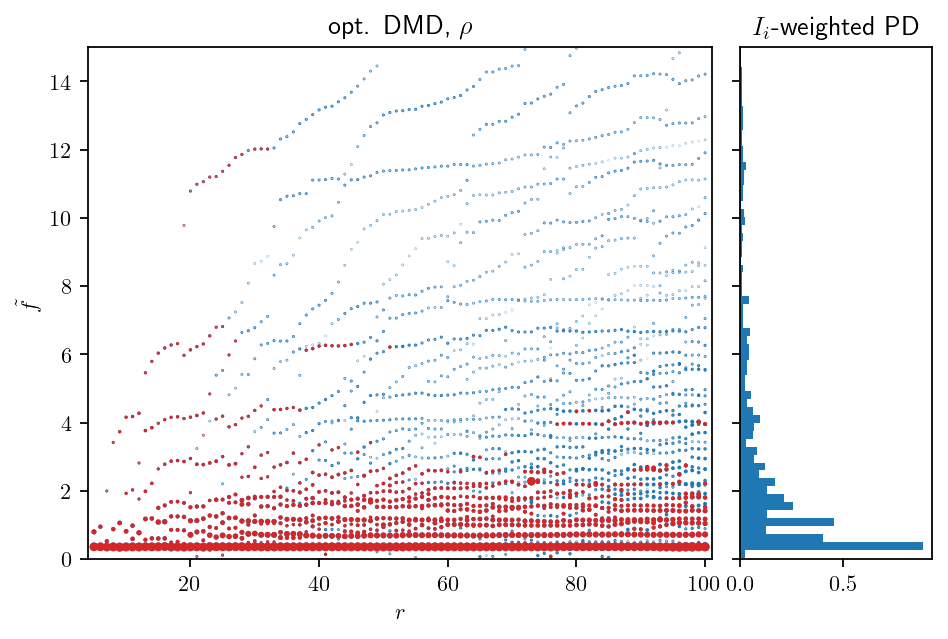

In [7]:
plot_spectra_over_rank(freq1, integral1, test_ranks, 10, 100, r"opt. DMD, $\rho$")
plt.savefig(f"{output}f_over_rank_rho.png")
plt.show()

In [8]:
dmd_options = {
    "optimal" : True,
    "unitary" : True,
    "dt" : times[1] - times[0]
}

In [9]:
freq2, integral2 = [], []
for r in test_ranks:
    print(f"\rTesting r={r:3d}", end="")
    dmd = DMD(dm, rank=r, **dmd_options)
    freq2.append(dmd.frequency)
    integral2.append(dmd.integral_contribution)

Testing r=100

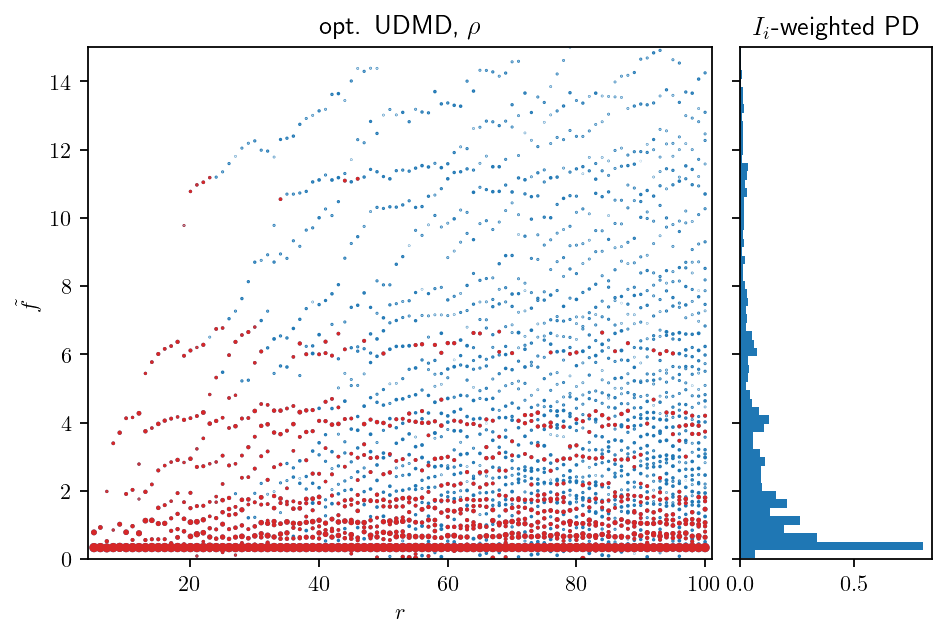

In [10]:
plot_spectra_over_rank(freq2, integral2, test_ranks, 10, 150, r"opt. UDMD, $\rho$")
plt.savefig(f"{output}f_over_rank_rho_unitary.png")
plt.show()

In [11]:
## velocity and speed of sound
dm = pt.zeros((3*n_points, n_times))
dm_full = pt.load(f"{data}slice/dm_ref1_z25.pt")[:, ::2]
dm[:2*n_points, :] = dm_full[:2*n_points, :] * w.repeat((2, 1))
kappa = pt.tensor(1.4)
scale = pt.sqrt(2.0 / (kappa * (kappa - 1.0)))
U = (dm_full[:n_points, :]**2 + dm_full[n_points:2*n_points, :]**2 + dm_full[2*n_points:3*n_points, :]**2).sqrt()
Ma = dm_full[4*n_points:, :]
dm[2*n_points:, :] = scale * (U / Ma) * w
del dm_full

In [12]:
dmd_options = {
    "optimal" : True,
    "dt" : times[1] - times[0]
}

In [13]:
freq3, integral3 = [], []
for r in test_ranks:
    print(f"\rTesting r={r:3d}", end="")
    dmd = DMD(dm, rank=r, **dmd_options)
    freq3.append(dmd.frequency)
    integral3.append(dmd.integral_contribution)

Testing r=100

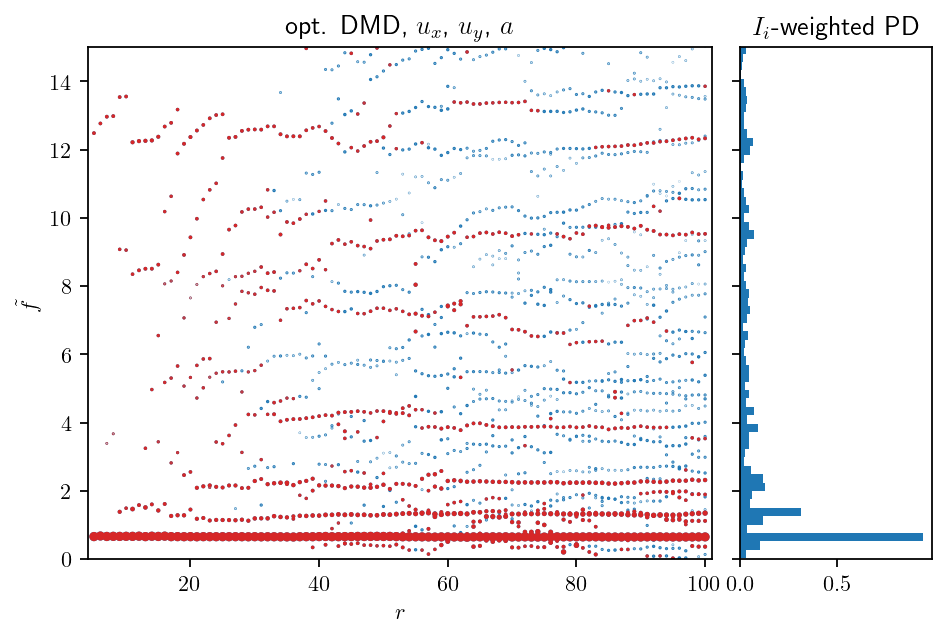

In [14]:
plot_spectra_over_rank(freq3, integral3, test_ranks, 10, 150, r"opt. DMD, $u_x$, $u_y$, $a$")
plt.savefig(f"{output}f_over_rank_uxya.png")
plt.show()

In [15]:
dmd_options = {
    "optimal" : True,
    "unitary" : True,
    "dt" : times[1] - times[0]
}

In [16]:
freq4, integral4 = [], []
for r in test_ranks:
    print(f"\rTesting r={r:3d}", end="")
    dmd = DMD(dm, rank=r, **dmd_options)
    freq4.append(dmd.frequency)
    integral4.append(dmd.integral_contribution)

Testing r=100

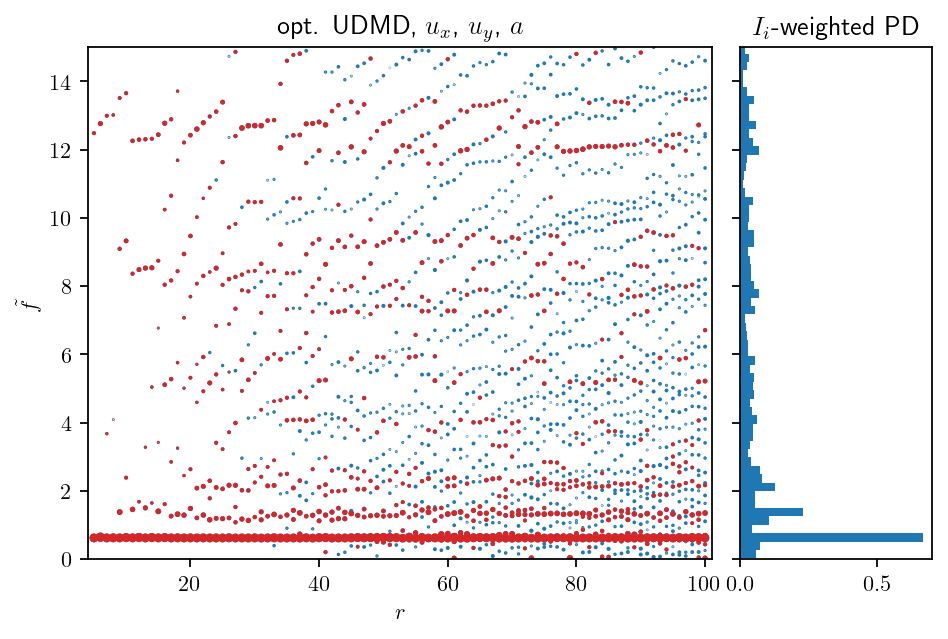

In [17]:
plot_spectra_over_rank(freq4, integral4, test_ranks, 10, 150, r"opt. UDMD, $u_x$, $u_y$, $a$")
plt.savefig(f"{output}f_over_rank_uxya_unitary.png")
plt.show()